### EU_email

In [45]:
import numpy as np
import pandas as pd
import random
import time
from sklearn.model_selection import RepeatedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import linalg
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import requests
%run GraphEncoder.ipynb
#from scipy.spatial import procrustes
import math

from graspologic.embed import AdjacencySpectralEmbed

In [46]:
import networkx as nx
from scipy.sparse import csr_array
from graspologic.simulations import rdpg
#from scipy.linalg import irlba
#from scipy.spatial import procrustes
%run GraphEncoder.ipynb
import leidenalg as la
import igraph as ig
import scipy.sparse as sp
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from gae.layers import GraphConvolution
from gae.model import GCNModelVAE
from gae.utils import load_data, mask_test_edges, preprocess_graph, get_roc_score
from gae.optimizer import loss_function

In [48]:
def adj_to_edg(A):
    """
      input is the symmetric adjacency matrix: A
      other variables in this function:
      s: number of edges
      return edg_list -- matrix format with shape(edg_sum,3):
      example row in edg_list(matrix): [vertex1, vertex2, connection weight from Adj matrix]
    """
    # check the len of the second dimenson of A
    if A.shape[1] <= 3:
      edg = A
    else:
      n = A.shape[0]
      # construct the initial edgg_list matrix with the size of (edg_sum, 3)
      edg_list = []
      for i in range(n):
        for j in range(i, n):
          if A[i,j] > 0:
            row = [i, j, A[i,j]]
            edg_list.append(row)
      edg = np.array(edg_list)
    return edg

def procrustes(X, Y, type="I"):
    if type == "C":
        X = X / np.linalg.norm(X, ord="fro") * np.sqrt(X.shape[0])
        Y = Y / np.linalg.norm(Y, ord="fro") * np.sqrt(Y.shape[0])
    if type == "D":
        tX = np.sum(X ** 2, axis=1)
        tX[tX <= 1e-15] = 1
        tY = np.sum(Y ** 2, axis=1)
        tY[tY <= 1e-15] = 1
        X = X / np.sqrt(tX)[:, np.newaxis]
        Y = Y / np.sqrt(tY)[:, np.newaxis]

    tmp = X.T @ Y
    U, s, Vt = np.linalg.svd(tmp,full_matrices=False)
    W = U @ Vt
    error = np.linalg.norm(X @ W - Y, ord="fro")
    
    return {"error": error, "W": W}


In [49]:
def GCN_emb(model, features, adj_norm_matrix, adj_label,n, decay,learning_rate, epochs = 200):
    optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate,
      weight_decay=decay) #weight decay is important!

    # get class weight
    pos_weight = ((adj_label.shape[0] * adj_label.shape[0] - adj_label.sum()) / adj_label.sum())
    # get adj norm
    adj_norm = adj_label.shape[0] * adj_label.shape[0] / float((adj_label.shape[0] *adj_label.shape[0] - adj_label.sum()) * 2)

    # Training the VAE   
    while True: #we can try 20 different random weight init runs to get an average 
        # initialize weights randomly => impact on convergence
        model.gc1.reset_parameters()
        model.gc2.reset_parameters()
        model.gc3.reset_parameters()  
        # Training
        for epoch in range(0, epochs + 1):
            model.train()
            optimizer.zero_grad()
            # ===================forward=====================
            adj_hat, mu, logvar = model(features,adj_norm_matrix)        
            loss = loss_function(adj_hat,adj_label,mu,logvar,n,adj_norm,pos_weight) #might reduce the KL term regularization
            # log
            if epoch == 0:
              init_loss = loss.item()
            # if epoch% 50 == 0:
            #   print('loss: ', loss.item())
            # ===================backward====================
            loss.backward()
            optimizer.step()
        # Check convergence
        if (init_loss-loss.item())/loss.item() > 0.05: 
            break
        else:
          print(model)
          print('not converged yet, reset params and rerun')

  # Get GCN embedding
    with torch.no_grad():
      model.eval()
      adj_hat, mu, logvar = model(features, adj_norm_matrix)
      z = model.reparameterize(mu, logvar) 

    return z

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def preprocess_graph(adj_):
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten()) #D^-0.5
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()  #D^-0.5 A D^-0.5
    return sparse_mx_to_torch_sparse_tensor(adj_normalized), sparse_mx_to_torch_sparse_tensor(adj_)

def adj_in_out(adj):
    row, col = np.where(adj)
    coo = np.rec.fromarrays([row, col, adj[row, col]], names='row col value'.split())
    out = sp.coo_matrix((coo['value'], (coo['row'], coo['col'])), (adj.shape[0], adj.shape[1]))
    #Adjacency normalized matrix and label for GVAE usage
    adj_norm_matrix, adj_matrix = preprocess_graph(out)
    adj_label = torch.FloatTensor(out.toarray())
    return adj_norm_matrix, adj_matrix, adj_label#, out

In [50]:
row, col = np.where(adj0)
coo = np.rec.fromarrays([row, col, adj0[row, col]], names='row col value'.split())
out = sp.coo_matrix((coo['value'], (coo['row'], coo['col'])), (adj0.shape[0], adj0.shape[1]))
    #Adjacency normalized matrix and label for GVAE usage
adj_norm_matrix, adj_matrix = preprocess_graph(out)
adj_label = torch.FloatTensor(out.toarray())

In [194]:
sum(adj_label[:,4])
adj_matrix

tensor(indices=tensor([[   0,    0,    0,  ..., 1002, 1003, 1004],
                       [   0,    1,    5,  ...,  560,  258,   55]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(1005, 1005), nnz=32770, layout=torch.sparse_coo)

In [51]:
df = pd.read_csv (r'/Users/tongqi/Desktop/papersandbooks/codes/GEE_ASE/data/email-Eu-core-department-labels.txt',
                  sep = ' ', header = None)
y = df.to_numpy()
ys= y[:,1].reshape((len(y[:,1]),1))
print(len(y[:,1]))
#len(np.unique(y[:,1]))

1005


In [52]:
df2 = pd.read_csv (r'/Users/tongqi/Desktop/papersandbooks/codes/GEE_ASE/data/email-Eu-core.txt',
                   header = None,sep = ' ')
Edge = df2.to_numpy()
print(Edge)

[[  0   1]
 [  2   3]
 [  2   4]
 ...
 [440 460]
 [ 52 786]
 [506 932]]


In [53]:
A0 = np.zeros((1005,1005))
for i in range (0,25571):
    A0[Edge[i,0],Edge[i,1]]=1
#print(A0)
A0.astype(int)

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [54]:
A1 = np.maximum( A0, A0.transpose() )

In [55]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(A1)

True

In [56]:
################# Embed on A0
n=len(y[:,1])
K=int(y.max())
edgelist0 = adj_to_edg(A1)

d=2 # from R getElbow

graph0 = nx.from_numpy_matrix(A1,parallel_edges=False, create_using=None)
adj0 = nx.to_numpy_array(graph0, dtype=int)
ase = AdjacencySpectralEmbed(n_components=d, algorithm='truncated')
############ ASE A0
ASE_Xhat0 = ase.fit_transform(adj0)
############  GEE A0
Z0, W0 = graph_encoder_embed(edgelist0,ys,n,Correlation= False)
Z0.shape

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)


(1005, 42)

In [57]:
######## define clique sizes

clique_sizes = [math.log(n),math.log(n)**2, 0.08*n,0.1*n,0.15*n,0.2*n]
clique_sizes = [ int(x) for x in clique_sizes ]
print(clique_sizes)


[6, 47, 80, 100, 150, 201]


In [58]:
# clean code

GEE_dist = []
ASE_dist = []
GAE_dist = []
n_c = []
EU_data = []

GEE_fnorm = []
GAE_fnorm = []

sim = 50
random.seed(118)

for clique in clique_sizes:
    for i in range(sim):
        
        c_vertices = random.sample(range(0,n),clique) 
        full_g = nx.complete_graph(c_vertices)

        full_edges = list(full_g.edges())
        edges = list(graph0.edges()) 
        all_edges = set(edges).union(set(full_edges))

        #graph1 = nx.Graph(all_edges)
        #!!!!!!!!!!!!!!!!!!!! test 
        graph1 = nx.Graph()
        graph1.add_nodes_from(sorted(graph0.nodes(data=True)))
        graph1.add_edges_from(all_edges)
        

        # Check if nodes are connected in both graphs
         #print(graph0.has_edge(0, 4))
         #print(graph1.has_edge(0, 4))

        adj1 = nx.to_numpy_array(graph1, dtype=int)

        edgelist1 =  adj_to_edg(adj1)
        Z1, W1 = graph_encoder_embed(edgelist1,ys,n,Correlation= False)
        ################ GEE dist ####################
        GEEd = procrustes(Z1,Z0)['error']
        GEE_dist.append(GEEd)
        
        GEE_fd = np.linalg.norm(Z0 - Z1, "fro")
        GEE_fnorm.append(GEE_fd)

        ############### ASE dist ############## 
         #ASE_Xhat0 = ase.fit_transform(adj0)
        ASE_Xhat1 = ase.fit_transform(adj1)

        ASE_d = procrustes(ASE_Xhat1,ASE_Xhat0)['error']
        ASE_dist.append(ASE_d)

        ################ VGAE ##############
        dim = d
        features = torch.eye(n)
        model_GAE = GCNModelVAE(n, 2*dim, dim, 0) #init new instance everytime. Can change 0 to other dropout rates

        adj0 = nx.to_numpy_array(graph0, dtype=int)
        adj_norm_matrix0, adj_matrix0, adj_label0 = adj_in_out(adj0)
        GAE_0 = GCN_emb(model_GAE, features, adj_norm_matrix0, adj_label0,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_0 = GAE_0.numpy()
        adj1 = nx.to_numpy_array(graph1, dtype=int)
        adj_norm_matrix1, adj_matrix1, adj_label1 = adj_in_out(adj1)
        GAE_1 = GCN_emb(model_GAE, features, adj_norm_matrix1, adj_label1,n,decay=0, learning_rate=1e-2) #initial benchmark: decay = 1e-3; investigate 0 weight decay w/ dropout on 
        GAE_1 = GAE_1.numpy()
        GAE_d = procrustes(GAE_1,GAE_0)
        GAE_d = GAE_d['error']
        GAE_dist.append(GAE_d)
        
        GAE_fd = np.linalg.norm(GAE_0 - GAE_1, "fro")
        GAE_fnorm.append(GAE_fd)

        n_c.append(clique)
        df_id = str(clique)
        
    sim_data = np.column_stack((ASE_dist, GEE_dist,GAE_dist,n_c,GEE_fnorm,GAE_fnorm))
    sim_data = pd.DataFrame(sim_data, columns = ['ASE_dist','GEE_dist','VGAE_dist','n_c',
                                                 'GEE_fnorm','GAE_fnorm'])
    sim_data.to_csv("./sim_data/EU_sym"+df_id+".csv", sep=',', index=False)
EU_data.append(sim_data)


#print(EU_data)



/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

GCNModelVAE(
  (gc1): GraphConvolution (1005 -> 4)
  (gc2): GraphConvolution (4 -> 2)
  (gc3): GraphConvolution (4 -> 2)
  (dc): InnerProductDecoder()
)
not converged yet, reset params and rerun


/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/tongqi/miniforge3/lib/python3.9/site-packages/graspologic/embed/base.py:199: UserWarning: 

In [240]:
readdata.head(3)

,ASE,GEE,VGAE_dist,Clique,GEE_Fnorm,VGAE
0,0.018016,6.044092,13.782383,6.0,6.150567,20.941805
1,0.061137,6.020328,10.959078,6.0,6.127300,36.035774
2,0.040317,6.025219,13.015982,6.0,6.131626,38.422852


In [63]:
#data = np.reshape(EU_data, (len(n_c), 4))
#df = pd.DataFrame(data)
#df.columns =['ASE','GEE','GAE','Clique']

readdata = pd.read_csv ('./sim_data/EU_sym201.csv',sep=',',header = 0)
readdata = readdata.rename(columns={'n_c': 'Clique','GAE_fnorm':'VGAE_Fnorm',
                                    'GEE_fnorm':'GEE_Fnorm',
                                   'GEE_dist':'GEE','ASE_dist':'ASE', }) 
distdf = readdata.drop(columns =['VGAE_dist','GEE'])
#distdf = readdata.drop(columns =['VGAE_dist'])
meltdf = pd.melt(distdf, id_vars=['Clique'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['Clique', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)
finaldf['Clique'] = finaldf['Clique'].astype(int)
finaldf.loc[finaldf['Clique'] ==6  , 'Cliquesize'] = 'log(n)'
finaldf.loc[finaldf['Clique'] == 47, 'Cliquesize'] = 'log(n)^2'
finaldf.loc[finaldf['Clique'] == 80, 'Cliquesize'] = '0.08*n'
finaldf.loc[finaldf['Clique'] == 100, 'Cliquesize'] = '0.1*n'
finaldf.loc[finaldf['Clique'] == 150, 'Cliquesize'] = '0.15*n'
finaldf.loc[finaldf['Clique'] == 201, 'Cliquesize'] = '0.2*n'
finaldf

,Clique,variable,value_min,value_mean,value_max,value_std,Cliquesize
0,6,ASE,0.011094,0.043398,0.123399,0.023613,log(n)
1,6,GEE_Fnorm,0.100213,0.392331,2.260202,0.425507,log(n)
2,6,VGAE_Fnorm,9.940817,35.489476,52.452530,11.196715,log(n)
3,47,ASE,7.522214,8.333971,9.024853,0.491885,log(n)^2
4,47,GEE_Fnorm,2.139693,3.513675,8.190126,1.344669,log(n)^2
5,47,VGAE_Fnorm,11.264812,35.919185,55.720821,10.800742,log(n)^2
6,80,ASE,9.792780,10.329940,10.580093,0.207248,0.08*n
7,80,GEE_Fnorm,4.752781,7.038178,13.742358,2.154131,0.08*n
8,80,VGAE_Fnorm,13.478475,34.805662,54.053555,10.685893,0.08*n
9,100,ASE,10.805622,11.148993,11.386718,0.160118,0.1*n


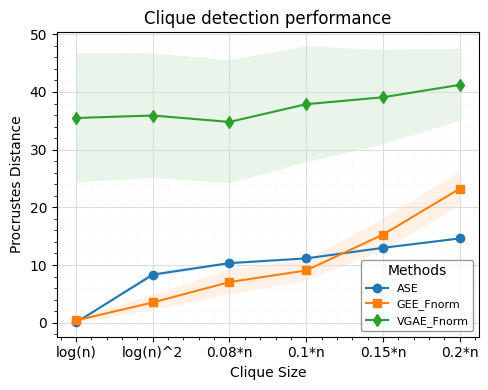

In [61]:
# CAUTION

fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['Cliquesize'], group['value_mean'], label=variable)
    ax.fill_between(group['Cliquesize'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Clique Size', ylabel='Procrustes Distance',
       title='Clique detection performance')
# ax.set_facecolor("white")

# set markers
#markers = ['o', 's', 'd','v','x','8']
markers = ['o', 's', 'd','v','x',]
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 4,title="Methods",fontsize=8,fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
#plt.savefig('./plots/EU_email4.png')

# plots for normalized and regular Procrustes distance

In [18]:
# CAUTION 
# LOAD DATA
#readdata = pd.read_csv ('./sim_data/new_sim/rdpgnocluster_02n1500.csv',sep=',',header = 0)
readdata = pd.read_csv ('./sim_data/rdpg3cluster_logn1500.csv',sep=',',header = 0)
readdata = readdata.rename(columns={'GAE_nml':'VGAE_nml'}) 
print(readdata.head(3))

#distdf = readdata[['ASE_dist','GEE_dist','n','VGAE_Fnorm','GEE_dist2','GEE_fnorm']]
distdf = readdata[['ASE_dist','GEE_dist','n','VGAE_Fnorm','GEE_fnorm']]
meltdf = pd.melt(distdf, id_vars=['n'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['n', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)



   ASE_dist  GEE_dist  VGAE_dist   ASE_nml   GEE_nml  VGAE_nml      n  \
0  6.429475  3.741065   1.154845  0.133485  0.077670  0.023976  100.0   
1  5.876256  4.367942   0.994954  0.128169  0.095271  0.021701  100.0   
2  6.246256  4.227932   1.229108  0.134585  0.091097  0.026483  100.0   

   GEE_fnorm  VGAE_Fnorm  
0   4.542036    4.485688  
1   5.103937    3.905960  
2   4.609610    4.652711  


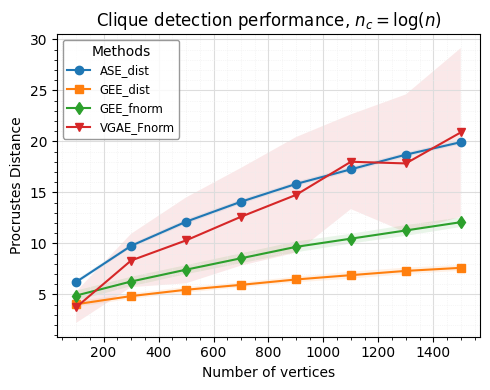

In [19]:
# CAUTION

fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['n'], group['value_mean'], label=variable)
    ax.fill_between(group['n'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Procrustes Distance', 
       title='Clique detection performance, $n_c = \log(n)$')#+cliquesize) $$$$$$$$$$$$$$$$$$$$$$$$$
# ax.set_facecolor("white")

# set markers
markers = ['o', 's', 'd','v','8']
#markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 2,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')

#plt.show()
#plt.savefig('./plots/newplots2/rdpg3_02n.png') #+ cliquesize + '.png')


# add and calculate the nlm for Fnorms, RDPG or 3-RDPG

In [228]:
# LOAD DATA
#adjnorms = pd.read_csv ('./sim_data/new_sim/rdpgnocluster_adj0_norms1500.csv',sep=',',header = 0)
#adjnorms = pd.read_csv ('./sim_data/new_sim/rdpg3_adj0_norms1500.csv',sep=',',header = 0)
#adjnorms = adjnorms.rename(columns={'n':'nnn'}) 
#print(adjnorms.head(3))
#test = pd.concat([readdata, adjnorms], axis=1)
#test['GEE_nml2']=test['GEE_dist2']/test['adj0_norm']
#test['VGAE_Fnml'] = test['VGAE_Fnorm']/test['adj0_norm']
print(test.tail(3))
#readdata['GEE_nml2']=readdata['GEE_dist2']/readdata['adj0_norms']
readdata['VGAE_Fnml']=readdata['VGAE_Fnorm']/readdata['adj0_norms']
#print(readdata.head(3))

     ASE_dist  GEE_dist  VGAE_dist   ASE_nml   GEE_nml  VGAE_nml       n  \
397  0.255874  1.379022   1.255923  0.000361  0.001947  0.001773  1500.0   
398  0.088138  0.701228   0.176433  0.000125  0.000998  0.000251  1500.0   
399  0.036136  0.730720   0.300854  0.000052  0.001049  0.000432  1500.0   

     GEE_fnorm  VGAE_Fnorm   adj0_norm     nnn  VGAE_Fnml  
397   1.677959   22.606569  710.194340  1500.0   0.031832  
398   0.723367   23.007046  703.592211  1500.0   0.032699  
399   0.809152   21.548809  701.893154  1500.0   0.030701  


In [229]:
# get the normalized sub datafile
#nmldf = test[['ASE_nml','VGAE_Fnml','GEE_nml','GEE_nml2','n']]
#nmldf = readdata[['ASE_nml','VGAE_Fnml','GEE_nml','GEE_nml2','n']]
nmldf = readdata[['ASE_nml','VGAE_Fnml','GEE_nml','n']]
#nmldf = readdata[['ASE_nml','VGAE_Fnml','GEE_nml','n']]
meltdf = pd.melt(nmldf, id_vars=['n'], var_name='variable', value_name='value')
summary_functions = {'value': ['min', 'mean', 'max', 'std']}
finaldf = meltdf.groupby(['n', 'variable']).agg(summary_functions)
finaldf.columns = ['_'.join(col).strip() for col in finaldf.columns.values]
finaldf.reset_index(inplace=True)

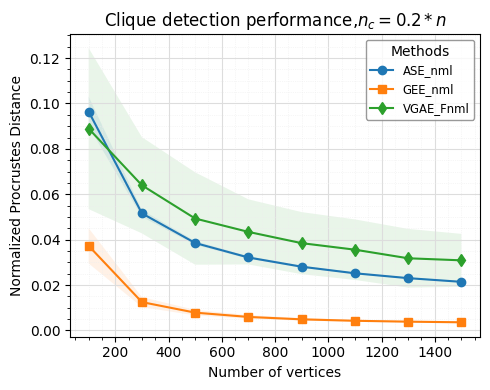

In [231]:
# CAUTION
# for normalized plots
fig, ax = plt.subplots(figsize=(5, 4))
#fig.patch.set_facecolor("#fafafa")
#ax.set_facecolor("#fafafa")

for item in [fig, ax]:
    item.patch.set_visible(True)

for variable, group in finaldf.groupby('variable'):
    ax.plot(group['n'], group['value_mean'], label=variable)
    ax.fill_between(group['n'], group['value_mean'] - group['value_std'], 
                    group['value_mean'] + group['value_std'], alpha=0.1)
    ax.grid(True)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.minorticks_on()
    

ax.set(xlabel='Number of vertices', ylabel='Normalized Procrustes Distance', 
       title='Clique detection performance, $n_c = 0.2*n$')   #+cliquesize) $$$$$$$$$$$$$$$$$$$$$$
# ax.set_facecolor("white")

# set markers
markers = ['o', 's', 'd','v','x','8']
#markers = ['o', 's', 'd','v']
#markers = ['o', 's', 'd']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

#ax.legend(ax.get_lines(), finaldf.columns, loc='upper left', ncol=2)

plt.tight_layout()

legend = plt.legend(frameon = 1,loc = 1,title="Methods",fontsize='small',fancybox=True )
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('grey')


#plt.show()
#plt.savefig('./plots/newplots2/rdpg3_02n_nml.png')# + cliquesize + '.png')
